## Description
This notebook is a test of the Monte Carlo simulation of temperature data by using different implementations.


In [22]:
import numpy as np
from tqdm import tqdm
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from compstat_research.config import PROCESSED_DATA_DIR, MPLSTYLE_DIR

plt.style.use(MPLSTYLE_DIR / "iragca_ml.mplstyle")

In [3]:
data_dir = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

daily_temp = pl.read_parquet(data_dir / "era5-2m-temperature-global-daily-avg.parquet")
yearly_temp = pl.read_parquet(data_dir / "era5-2m-temperature-global-yearly-avg.parquet")
daily_temp.head()

temp_year,temp_month,temp_day,avg_temp
i64,i64,i64,f64
1940,1,2,276.007051
1940,1,3,275.975732
1940,1,4,275.934177
1940,1,5,275.893011
1940,1,6,275.7141


## Base Implementation, very slow

In [12]:
iterations = []

for iteration in tqdm(range(100)):
    yearly_avg_temps = []
    for year in range(85):
        day_temps = []
        for day in range(365):
            day_temps.append(daily_temp["avg_temp"].sample(1).item())
        yearly_avg_temps.append(sum(day_temps) / 365)
    iterations.append(yearly_avg_temps)


100%|██████████| 100/100 [06:11<00:00,  3.72s/it]


Text(0, 1, 'Average Temperature (K)')

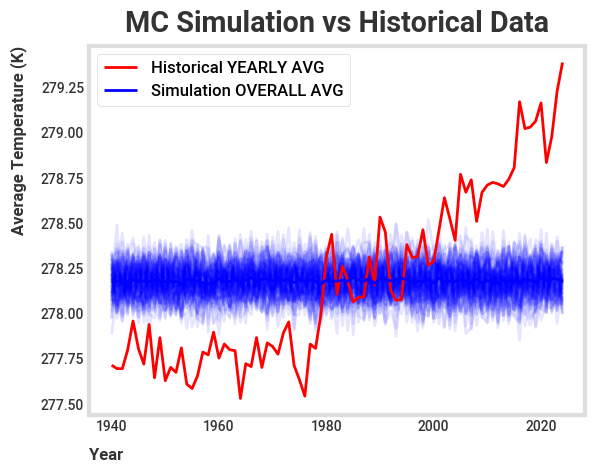

In [20]:
for iteration in iterations:
    sns.lineplot(x=range(1940, 1940 + 85), y=iteration, alpha=0.1, color='blue', label='_nolegend_')

# Plot historical data
sns.lineplot(data=yearly_temp, x="temp_year", y="avg_temp", 
            color='red', label='Historical YEARLY AVG')
# Plot mean of simulations
sns.lineplot(x=range(1940, 1940 + 85), y=np.array(iterations).mean(axis=0), 
            color='blue', label='Simulation OVERALL AVG')
plt.title('MC Simulation vs Historical Data')
plt.xlabel('Year')
plt.ylabel('Average Temperature (K)')

## Numpy implementation, blazingly fast

In [32]:
def simulate_daily_temperatures(temp_data, n_days):
    """Simulate daily temperatures by randomly sampling from historical data."""
    return np.random.choice(temp_data["avg_temp"], size=n_days)

def simulate_yearly_averages(temp_data, start_year, n_years, n_iterations=100):
    """
    Run Monte Carlo simulation for yearly temperature averages.
    
    Args:
        temp_data: Polars DataFrame with historical temperature data
        start_year: First year of the simulation
        n_years: Number of years to simulate
        n_iterations: Number of Monte Carlo iterations
    
    Returns:
        tuple: (years array, simulated temperatures array [iterations x years])
    """
    DAYS_PER_YEAR = 365
    years = np.arange(start_year, start_year + n_years)
    
    # Pre-allocate array for all iterations [iterations x years]
    results = np.zeros((n_iterations, n_years))
    
    for i in tqdm(range(n_iterations), unit="iterations"):
        # Simulate daily temperatures for all years at once
        daily_temps = simulate_daily_temperatures(temp_data, n_years * DAYS_PER_YEAR)
        # Reshape to [n_years x days_per_year] and compute yearly averages
        yearly_temps = daily_temps.reshape(n_years, DAYS_PER_YEAR).mean(axis=1)
        results[i] = yearly_temps
    
    return years, results

In [33]:
years, simulated_data = simulate_yearly_averages(
    temp_data=daily_temp,
    start_year=1940,
    n_years=85,
    n_iterations=100
)

100%|██████████| 100/100 [00:00<00:00, 2941.10iterations/s]


Text(0, 1, 'Average Temperature (K)')

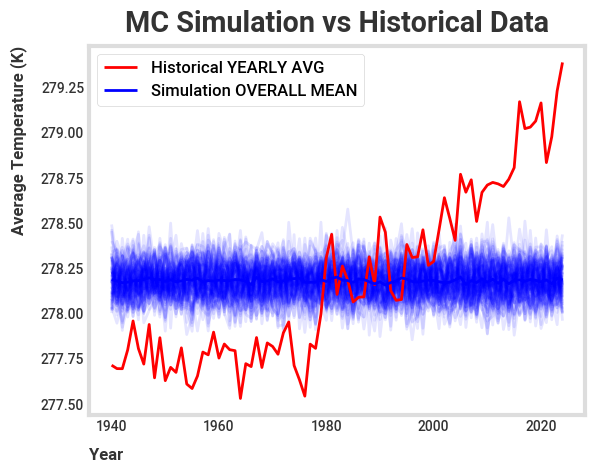

In [21]:
# plt.figure(figsize=(12, 6))
# Plot all Monte Carlo iterations (lighter color)
for iteration in simulated_data:
    sns.lineplot(x=years, y=iteration, alpha=0.1, color='blue', label='_nolegend_')
# Plot historical data
sns.lineplot(data=yearly_temp, x="temp_year", y="avg_temp", 
            color='red', label='Historical YEARLY AVG')
# Plot mean of simulations
sns.lineplot(x=years, y=simulated_data.mean(axis=0), 
             
            color='blue', label='Simulation OVERALL MEAN')
plt.title('MC Simulation vs Historical Data')
plt.xlabel('Year')
plt.ylabel('Average Temperature (K)')